In [49]:
import logging
from argparse import ArgumentParser

import torch
import torch.nn.functional as F
# import wandb
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from tqdm import trange

from experiments.data import INRDataset
from experiments.utils import (
    common_parser,
    count_parameters,
    get_device,
    set_logger,
    set_seed,
    str2bool,
)
from nn.models import DWSModelForClassification, MLPModelForClassification , DWSModel

from experiments.mnist.generate_data_splits import generate_splits
from experiments.mnist.compute_statistics import compute_stats

set_logger()

In [50]:
# print(torch.cuda.current_device())  # The ID of the current GPU
# print(torch.cuda.get_device_name(0))  # The name of the specified GPU
# print(torch.cuda.device_count())  # The amount of GPUs that are accessible

In [51]:
torch.cuda.empty_cache()

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False

In [53]:
# generate_splits(data_path="notebooks/dataset/mnist-inrs", save_path="dataset")

In [54]:
# compute_stats(data_path="notebooks/dataset/mnist_splits.json", save_path="dataset", batch_size=1024)

## INR Dataset

We create INR Datasets and Dataloaders, and visualize some INRs (by reconstruction the images).



In [55]:
#Loading inr data we created while mnist training
import os
current_working_directory = os.getcwd()
print(current_working_directory)
path = current_working_directory + "/notebooks/dataset/mnist_splits.json"
statistics_path = current_working_directory + "/notebooks/dataset/statistics.pth"
normalize = True
augmentation = True

batch_size = 32
num_workers = 1

/work/talisman/sgupta/DWSNets/equivariant-diffusion


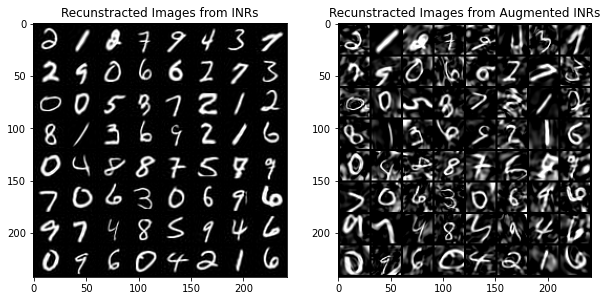

In [56]:
from torchvision.utils import save_image, make_grid
import torch

from experiments.data import INRImageDataset
from experiments.utils import set_seed
import matplotlib.pyplot as plt
dataset = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=False,
    split="train",
)

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

dataset_aug = INRImageDataset(
    path=path,  # path to splits json file
    augmentation=True,
    split="train",
)
loader_aug = torch.utils.data.DataLoader(dataset_aug, batch_size=64, shuffle=False)

batch = next(iter(loader))
batch_aug = next(iter(loader_aug))

fig, axs = plt.subplots(1, 2, figsize=(10,20)) 

axs[0].imshow(make_grid(batch.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[0].set_title('Recunstracted Images from INRs')

axs[1].imshow(make_grid(batch_aug.image.squeeze(-1)).permute(1, 2, 0).clip(0, 1))
axs[1].set_title('Recunstracted Images from Augmented INRs')
plt.show()

In [57]:
train_set = INRDataset(
        path=path,
        split="train",
        normalize=normalize,
        augmentation=augmentation,
        statistics_path=statistics_path,
    )

val_set = INRDataset(
    path=path,
    split="val",
    normalize=normalize,
    statistics_path=statistics_path,
)

test_set = INRDataset(
    path=path,
    split="test",
    normalize=normalize,
    statistics_path=statistics_path,
)

train_loader = torch.utils.data.DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
)

logging.info(
    f"train size {len(train_set)}, "
    f"val size {len(val_set)}, "
    f"test size {len(test_set)}"
)

2024-09-02 15:33:58,003 - root - INFO - train size 55000, val size 5000, test size 10000


In [58]:
point = train_set.__getitem__(4)
weight_shapes = tuple(w.shape[:2] for w in point.weights)
bias_shapes = tuple(b.shape[:1] for b in point.biases)
print(weight_shapes,bias_shapes)
# print(point.weights,point.biases,point.label)

(torch.Size([2, 32]), torch.Size([32, 32]), torch.Size([32, 1])) (torch.Size([32]), torch.Size([32]), torch.Size([1]))


In [59]:
# # shapes to initialize the DWSNet
# weight_shapes = tuple(w.shape[:2] for w in point.weights)
# bias_shapes = tuple(b.shape[:1] for b in point.biases)

# logging.info(
#     f"\nweight shapes: {weight_shapes}"
#     f"\nbias shapes: {bias_shapes}"
# )

# model = DWSModelForClassification(
#     weight_shapes=weight_shapes,
#     bias_shapes=bias_shapes,
#     input_features=1,
#     hidden_dim=32,
#     n_hidden=4,
#     bn=True,
# ).to(device)
# epochs =25

# epoch_iter = trange(epochs)
# criterion = nn.CrossEntropyLoss()
# test_acc = -1

# for epoch in epoch_iter:
#     for i, batch in enumerate(train_loader):
#         batch = batch.to(device)
#         inputs = (batch.weights, batch.biases)
#         out = model(inputs)
#         print(out)
#         break
#         loss = criterion(out, batch.label)
#         loss.backward()
#         optimizer.step()

#         epoch_iter.set_description(
#             f"[{epoch} {i+1}], train loss: {loss.item():.3f}, test acc: {test_acc:.3f}"
#         )
#         test_loss_dict = evaluate(model, test_loader)
#         test_acc = test_loss_dict['avg_acc'].item()

In [60]:
from typing import Tuple
import torch
import torch.nn as nn
from nn.layers import BN, DWSLayer
from nn.layers.base import BaseLayer,GeneralSetLayer

class DWSEncoder(BaseLayer):
    def __init__(
        self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="ds",
        add_layer_skip=False,
        input_dim_downsample=None,
        dropout_rate=0.0,
        init_scale=1e-4,
        init_off_diag_scale_penalty=1.0,
        bn=False,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        assert len(weight_shapes) > 2, "The implementation only supports networks with more than 2 layers."

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        self.init_scale = init_scale
        self.init_off_diag_scale_penalty = init_off_diag_scale_penalty
        self.diagonal = diagonal
        self.hidden_dims = hidden_dims
        self.in_features = input_features
        self.reduction = reduction
        self.add_layer_skip = add_layer_skip
        self.set_layer = set_layer

        self.skip = self._get_mlp(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
        )

        self.layers = nn.Sequential(
            DWSLayer(
                weight_shapes=weight_shapes,
                bias_shapes=bias_shapes,
                in_features=input_features,
                out_features=hidden_dims,
                reduction=reduction,
                bias=bias,
                n_fc_layers=n_fc_layers,
                num_heads=num_heads,
                set_layer=set_layer,
                add_skip=add_layer_skip,
                init_scale=init_scale,
                init_off_diag_scale_penalty=init_off_diag_scale_penalty,
                diagonal=diagonal,
            ),
            BN(hidden_dims, len(weight_shapes), len(bias_shapes)),
        )

        self.weight_shapes = weight_shapes

    def downsample_input_weights(self, inputs):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2)

        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1)
        inputs[1] = self._downsample_weight(inputs[1], dim=2)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1)

        return tuple(inputs)

    def downsample_input_biases(self, inputs):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0])

        # Downsample second bias dimension [32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_bias(inputs[1])

        return tuple(inputs)

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.layers(x)

        # Downsample weights and biases
        weights = self.downsample_input_weights(x[0])
        biases = self.downsample_input_biases(x[1])

        weight_shapes = tuple(w.shape[1:3] for w in weights)
        bias_shapes = tuple(b.shape[1:2] for b in biases)

        layers = nn.Sequential(
            DWSLayer(
                weight_shapes=weight_shapes,
                bias_shapes=bias_shapes,
                in_features=self.hidden_dims,
                out_features=self.in_features,
                reduction=self.reduction,
                bias=self.bias,
                n_fc_layers=self.n_fc_layers,
                num_heads=self.num_heads,
                set_layer=self.set_layer,
                add_skip=self.add_layer_skip,
                init_scale=self.init_scale,
                init_off_diag_scale_penalty=self.init_off_diag_scale_penalty,
                diagonal=self.diagonal,
            ),
            BN(self.in_features, len(weight_shapes), len(bias_shapes)),
        ).to(device)

        out = layers((weights, biases))
        return out

    def _downsample_weight(self, weight, dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [61]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # For Weight Reconstruction
        self.deconv_weight_1 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_21 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_22 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=(1, 1)),
        )
        self.deconv_weight_3 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=(1, 1)),   # Upsample to (32, 32, 1, 1)
        )

        # For Bias Reconstruction
        self.fc_bias_1 = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
        )
        self.fc_bias_2 = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
        )
        self.fc_bias_3 = nn.Sequential(
            nn.Linear(1, 1),
            nn.ReLU(),
            nn.Linear(1, 1),
        )

    def forward(self, x):
        # Decode weight tensors
        weight_space = x[0]
        bias_space = x[1]
        new_weight_space = []
        new_weight_space.append(self.deconv_weight_1(weight_space[0].permute(0,2,1,3)).permute(0,2,1,3))
        weight2_intermediate = self.deconv_weight_21(weight_space[1])
        new_weight_space.append(self.deconv_weight_22(weight2_intermediate.permute(0,2,1,3)).permute(0,2,1,3))
        new_weight_space.append(self.deconv_weight_3(weight_space[2]))

        new_bias_space = []
        # Decode bias tensors
        new_bias_space.append(self.fc_bias_1(bias_space[0].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_2(bias_space[1].squeeze(-1)).view(-1, 32, 1))
        new_bias_space.append(self.fc_bias_3(bias_space[2].squeeze(-1)).view(-1, 1, 1))

        return (tuple(new_weight_space), tuple(new_bias_space))


In [62]:
# Our AutoEncoder using DWSModel
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=2,
            reduction = max,
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)

        self.decoder = Decoder().to(device)
        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)
        output = self.decoder(encoded_data)
        return output

In [63]:
# Custom loss function for tuples of tensors because our AutoEncoder gets tensors as output (not sure if this is the correct approach)
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.base_loss = nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target
        total_loss = sum(self.base_loss(w1, w2) for w1, w2 in zip(weights1, weights2)) + \
             sum(self.base_loss(b1, b2) for b1, b2 in zip(biases1, biases2))

        return total_loss


In [64]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion =  TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss

In [65]:
# import logging
# import os
# import sys

# logging.basicConfig(filename='Outputs/training.log',
#                     level=logging.INFO,
#                     format='%(asctime)s - %(levelname)s - %(message)s',
#                     filemode='a')

# # Redirect print statements to logging
# class LoggerWriter(object):
#     def __init__(self, level):
#         self.level = level

#     def write(self, message):
#         if message.strip() != "":
#             logging.log(self.level, message.strip())

#     def flush(self):
#         pass

# sys.stdout = LoggerWriter(logging.INFO)
# sys.stderr = LoggerWriter(logging.INFO)

In [69]:
from tqdm import trange
from torch.optim.lr_scheduler import StepLR

def train_model(model):
    learning_rate = 1e-3
    num_epochs = 200
    criterion =  TupleLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=500, gamma=0.1)
    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        for i, batch in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()

            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)

            out = model(inputs)

            loss = criterion(out, inputs)
            loss.backward()
            optimizer.step()

            epoch_iter.set_description(
                f"[{epoch} {i+1}], train loss: {loss.item():.3f}, epoch loss: {epoch_loss:.3f}"
            )
            
            total_loss = total_loss + loss.item()
            counter +=1
#         test_loss =  evaluate(model, test_loader)
        epoch_loss = total_loss/counter
        scheduler.step()
        if (epoch+1)%25 == 0:
            torch.save(model.state_dict(), f"Outputs/model.pth")
            logging.info(evaluate(model, test_loader))
            
    

In [67]:
# # last_batch = last_batch.to(device)
# # nweight_shapes = tuple(w.shape for w in last_batch.weights)
# # nbias_shapes = tuple(b.shape for b in last_batch.biases)
# # print(nweight_shapes,nbias_shapes)
# # encoder = DWSEncoder(weight_shapes=weight_shapes,
# #                                 bias_shapes=bias_shapes,
# #                                 input_features=1,
# #                                 hidden_dims=4,
# #                                 downsample_dim = 8,
# #                                 n_hidden=2,
# #                                 reduction= "max",
# #                                 bn=True).to(device)
# output = encoder((last_batch.weights,last_batch.biases))
# weight_shapes = tuple(w.shape for w in output[0])
# bias_shapes = tuple(b.shape for b in output[1])
# print(weight_shapes,bias_shapes)
# decoder = Decoder().to(device)
# output = decoder(output)
# weight_shapes = tuple(w.shape for w in output[0])
# bias_shapes = tuple(b.shape for b in output[1])
# print(weight_shapes,bias_shapes)

In [ ]:
# #Model with DWS DownSample Layers
model2 = AutoEncoder(
    input_features=1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8,
    hidden_dims=4,
    reduction = "max",
    n_hidden=2,
    bn=False,
).to(device)
train_model(model2)


[28 832], train loss: 6.229, epoch loss: 6.316:  14%|█▍        | 28/200 [2:33:22<14:10:58, 296.85s/it] 

In [ ]:
# #Model with DWSLayers and Batch Normalization
# model3 = AutoEncoder(
#     input_features=1,
#     hidden_dims=[128,64,32],
#     n_hidden=3,
#     bn=True,
# ).to(device)
# train_model(model3)